In [1]:
import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
import pandas as pd 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score ,confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [2]:
%matplotlib inline

In [3]:
df = pd .read_csv('../input/voice.csv')

In [4]:
Nsamples, Nfeatures = df.shape
print(f'Nsamples:{Nsamples}\nNfeatures: {Nfeatures}')

Nsamples:3168
Nfeatures: 21


In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


<AxesSubplot:>

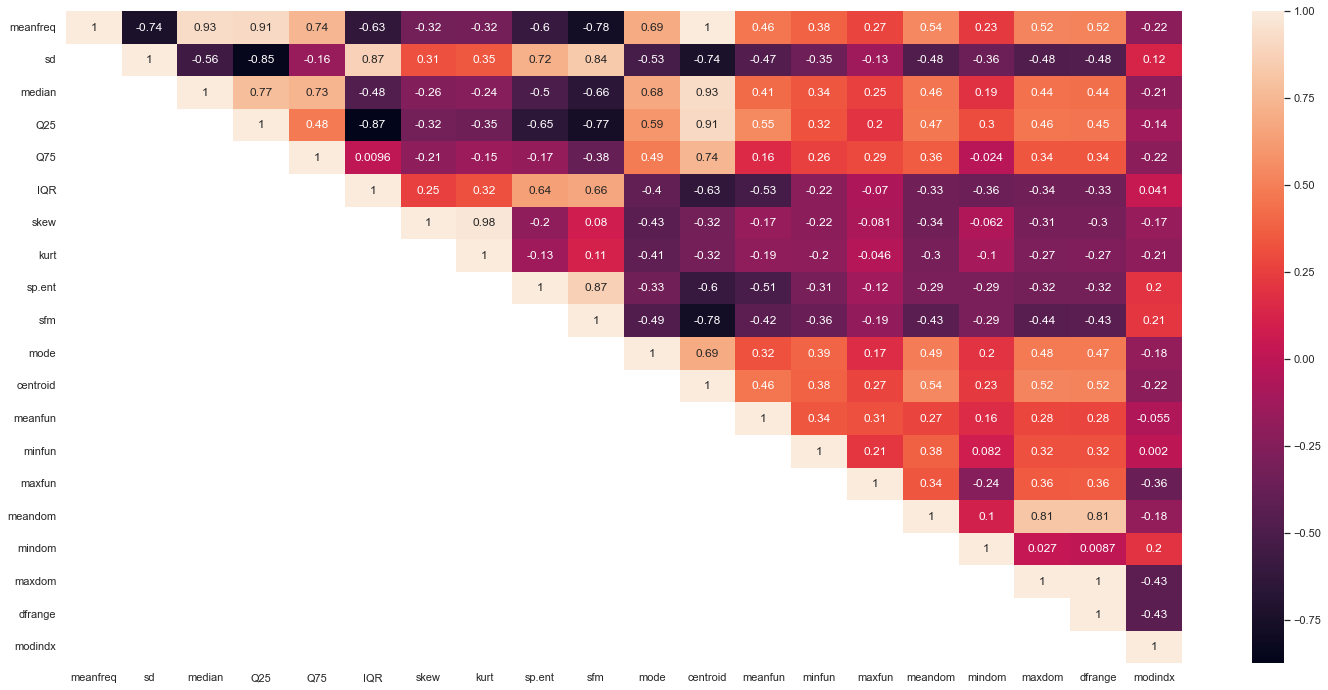

In [6]:
sns.set(style='whitegrid',color_codes=True)
cor_mat= df.corr(method='pearson')
mask = np.array(cor_mat)
mask[np.triu_indices_from(mask)] = False ## triangular inferior
fig=plt.gcf()
fig.set_size_inches(25,12)
sns.heatmap(data=cor_mat,mask=mask,annot=True,cbar=True)

## É possível observar que algumas das features são linearmente correlacionadas. Isso fornece índicios que é possível realizar uma redução de dimensionalidade para diminuir a redundância de features.

Temos como hipótese que as seguintes features são equivalentes:
- MeanFreq ~= Centroid
- dfrange ~= maxdom

## É interessante levantar algumas hipóteses sobre a distribuição dos dados.

In [7]:
def plot_male_female(feature):
    sns.catplot(data=df,y=feature, x='label',kind='box')
    fig=plt.gcf()
    fig.set_size_inches(10,10)

### Homens tendem a ter uma frequência média da voz mais baixa, i.e, grave.

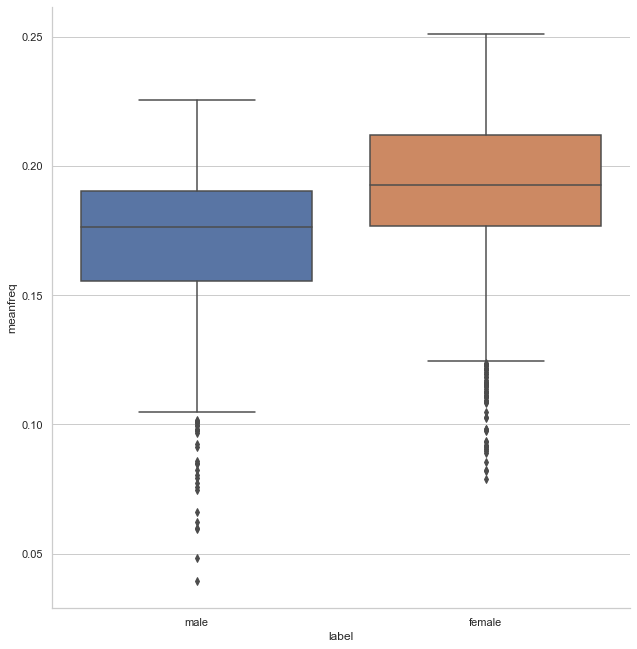

In [8]:
plot_male_female('meanfreq')

## Checando por valores de feature nulos 

In [9]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

## Enconding dos Labels e Balanceamento das classes. Como o número de amostras é igual nada muda.

In [10]:
print(df.label.value_counts())
dict = {'male':0,'female':1}
df.label.replace(dict,inplace = True)
df.head()

male      1584
female    1584
Name: label, dtype: int64


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,0


## Separação Amostras e Labels

In [11]:
X, y = df.loc[:, df.columns!='label'], df.loc[:, 'label']
X.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


# Classificação

In [12]:
cv = StratifiedKFold(n_splits=5,shuffle=True)
scores = {'acc' :make_scorer(accuracy_score), 
        'f1':make_scorer(f1_score)}

N_FEATURES_OPTIONS = list(range(1, X.shape[1]))
reducer_labels = ["PCA", "SVD"]
param_grid = [
    {
        "reduce_dim": [PCA(), TruncatedSVD()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
    }
]


## LDA

In [13]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", LinearDiscriminantAnalysis()),
    ]
)
grid_LDA = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv)
grid_LDA.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearDiscriminantAnalysis())]),
             param_grid=[{'reduce_dim': [PCA(n_components=12), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc',
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [14]:
results_LDA = pd.DataFrame(grid_LDA.cv_results_)
results_LDA[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",1,0.672036,0.685123
1,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",2,0.817548,0.809876
2,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",3,0.813763,0.806836
3,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",4,0.838382,0.822066
4,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",5,0.885099,0.878438
5,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",6,0.888571,0.882390
6,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",7,0.921718,0.919172
7,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",8,0.921404,0.918930
8,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",9,0.966226,0.965810
9,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",10,0.965910,0.965479


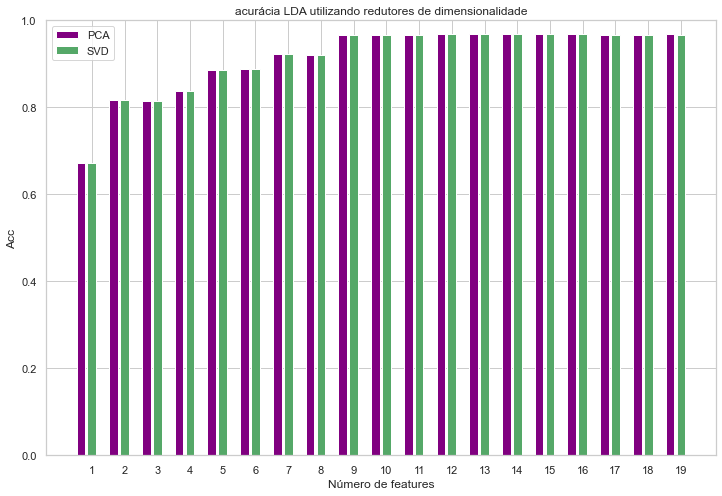

In [15]:
mean_scores = np.array(results_LDA["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("acurácia LDA utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## SVC

In [16]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", SVC(kernel='linear', C=10, gamma='scale')),
    ]
)

grid_SVC = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv)
grid_SVC.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        SVC(C=10, kernel='linear'))]),
             param_grid=[{'reduce_dim': [PCA(n_components=13), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc',
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [17]:
results_SVC = pd.DataFrame(grid_SVC.cv_results_)
results_SVC[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",1,0.682134,0.688233
1,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",2,0.827022,0.809447
2,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",3,0.827969,0.810032
3,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",4,0.838390,0.817749
4,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",5,0.886682,0.882320
5,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",6,0.885418,0.880501
6,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",7,0.942553,0.941935
7,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",8,0.942552,0.942116
8,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",9,0.974118,0.974066
9,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",10,0.974434,0.974412


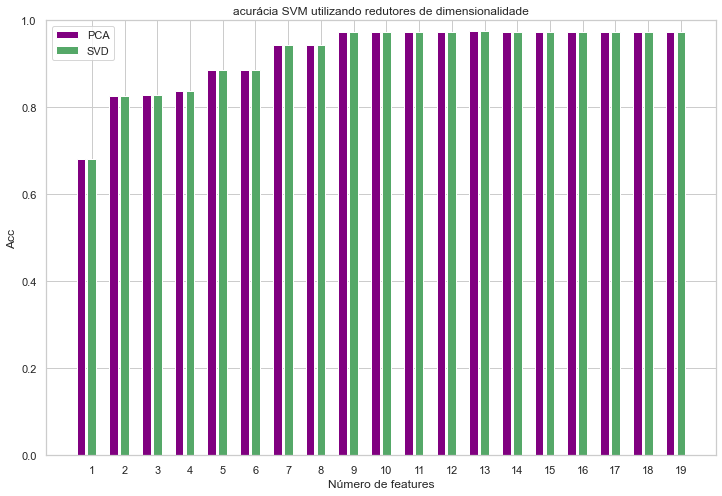

In [18]:
mean_scores = np.array(results_SVC["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("acurácia SVM utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## Random Forest

In [19]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", RandomForestClassifier()),
    ]
)
grid_RandomForest = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv)
grid_RandomForest.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', RandomForestClassifier())]),
             param_grid=[{'reduce_dim': [PCA(n_components=13),
                                         TruncatedSVD(n_components=16)],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc',
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [20]:
results_RandomForest = pd.DataFrame(grid_RandomForest.cv_results_)
results_RandomForest[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",1,0.650565,0.654170
1,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",2,0.819756,0.813508
2,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",3,0.847534,0.841950
3,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",4,0.871530,0.867529
4,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",5,0.936553,0.935340
5,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",6,0.946020,0.945230
6,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",7,0.958962,0.958560
7,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",8,0.961172,0.960875
8,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",9,0.970646,0.970519
9,"{'reduce_dim': PCA(n_components=13), 'reduce_d...",10,0.971275,0.971121


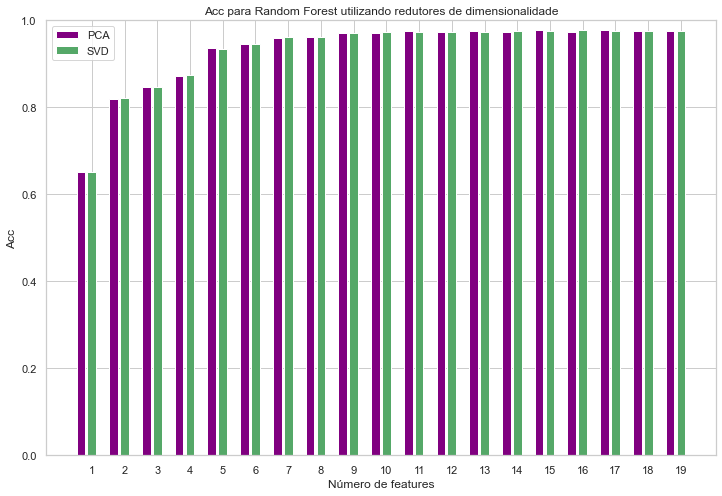

In [21]:
mean_scores = np.array(results_RandomForest["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acc para Random Forest utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## NN

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
accs = []
for i in range(1,51):
    for j in range(1,51):
        print(f'iteration {i}.{j}...')
        ANN = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,j), max_iter=2000).fit(X_train,y_train)
        y_pred_ANN = ANN.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred_ANN))


iteration 1.1...
iteration 1.2...
iteration 1.3...
iteration 1.4...
iteration 1.5...
iteration 1.6...
iteration 1.7...
iteration 1.8...
iteration 1.9...
iteration 1.10...
iteration 1.11...
iteration 1.12...
iteration 1.13...
iteration 1.14...
iteration 1.15...
iteration 1.16...
iteration 1.17...
iteration 1.18...
iteration 1.19...
iteration 1.20...
iteration 1.21...
iteration 1.22...
iteration 1.23...
iteration 1.24...
iteration 1.25...
iteration 1.26...
iteration 1.27...
iteration 1.28...
iteration 1.29...
iteration 1.30...
iteration 1.31...
iteration 1.32...
iteration 1.33...
iteration 1.34...


## IDEIAS PARA APRIMORAMENTO

- Ver quais features são menos relevantes, i.e, tem mais correlação entre si. 
- Levantar hipóteses sobre as features
- Descrição das Features.
- SVM fine tuning
- Finalizar NN utilizando o mesmo CV invés do train_test_split que usei nos outros classificadores
- Comparar os resultados



Sinta-se livre para remodelar ou utilizar outros classificadores. Se precisar que eu ajude só avisar